In [44]:
from tensorflow.python.ops.gen_clustering_ops import nearest_neighbors
from vtkmodules.vtkCommonCore import vtkDenseArray_IxE
from flame_analysis_model import *
from mpi4py import MPI
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
from matplotlib.colors import ListedColormap, BoundaryNorm
from sklearn.preprocessing import StandardScaler
import matplotlib as mpl
import umap
import hdbscan
plt.rcParams.update({
    "figure.dpi": 150,   # higher resolution
    "font.size": 11,     # larger fonts
})

In [45]:

time_step = 212
phi = 0.40
lat_size = 100
T_ref = 300
p_ref = 5e05
isolevels = [2.5, 3, 3.5, 4, 4.5, 4.7]
n_isolevels = len(isolevels)

folder_name = f"data/nek/phi{phi:.2f}/h400x{lat_size}_ref"
file_name = "premix"

In [46]:
rebuild_dataset = False
if rebuild_dataset:

    comm = MPI.COMM_WORLD
    rank = comm.rank

    # 2) Load dataset
    scalars = [
        'H2','O2', 'H2O', 'H', 'O', 'OH', 'HO2', 'H2O2', 'N2', 'heat_release',
        'curvature', 'stretch_rate', 'disp_speed_density_weighted',
        'abs_flame_prop_vel_normal', 'flow_velocity_normal',
        'flow_velocity_tangential', 'tangential_strain_rate',
        'normal_strain_rate', 'total_strain_rate', 'density_ratio_sigma',
        'vorticity'
    ]

    ds = SEMDataset(file_name=file_name, folder_name= folder_name,time_step= time_step, comm=MPI.COMM_WORLD, scalar_names=scalars)
    df = ds.create_dataframe(
        compute_vel_jacobian= False,
        compute_vel_hessian= False,
        compute_reaction_rates= True,
        cantera_inputs = ["../chemical_mech/BurkeH2.yaml", None, phi, T_ref, p_ref]
    )
    fig, ax = plt.subplots(figsize=(8, 10), dpi=150)
    for c in isolevels:
        # Extract flame front
        front = ds.extract_flame_front_unstruct(
            c_level=c,
        )
        # Save to csv
        front.to_csv(f"../data/isocontours/phi{phi:.2f}/h400x{lat_size}_ref/extracted_flame_front_{time_step}_iso_{c}.csv", index=False)
        # Plot
        ax.scatter(
            front["x"],
            front["y"],
            s=0.01,
            alpha=1,
            label=fr"$T={c}$"
        )

    ax.set_xlabel("x")
    ax.set_ylabel("y")
    ax.set_title(f"Temperature along flame fronts (phi={phi:.2f}, timestep={time_step})")
    ax.legend(markerscale=2, fontsize=8)
    ax.grid(True)

    plt.show()

phi0.40/h400x100_ref
Isolevels: [2.5, 3, 3.5, 4, 4.5, 4.7]
Feature setting: state


C:\Users\alexp\Documents\Bachelor Thesis\Code\.venv\Lib\site-packages\umap\umap_.py:1952: UserWarning: n_jobs value 1 overridden to 1 by setting random_state. Use no seed for parallelism.
  warn(


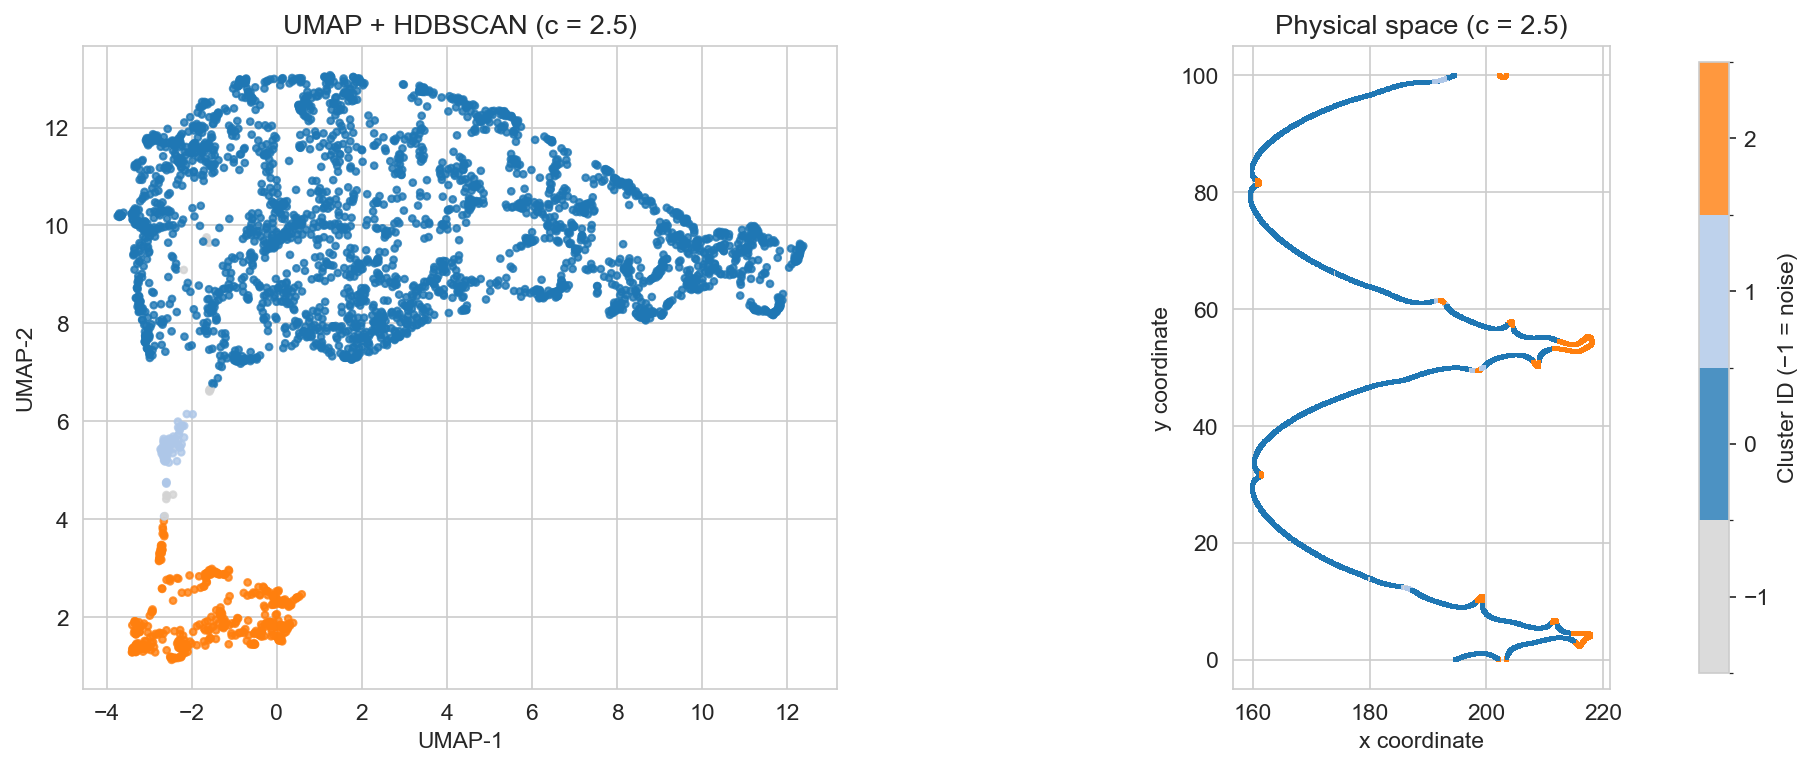

C:\Users\alexp\Documents\Bachelor Thesis\Code\.venv\Lib\site-packages\umap\umap_.py:1952: UserWarning: n_jobs value 1 overridden to 1 by setting random_state. Use no seed for parallelism.
  warn(


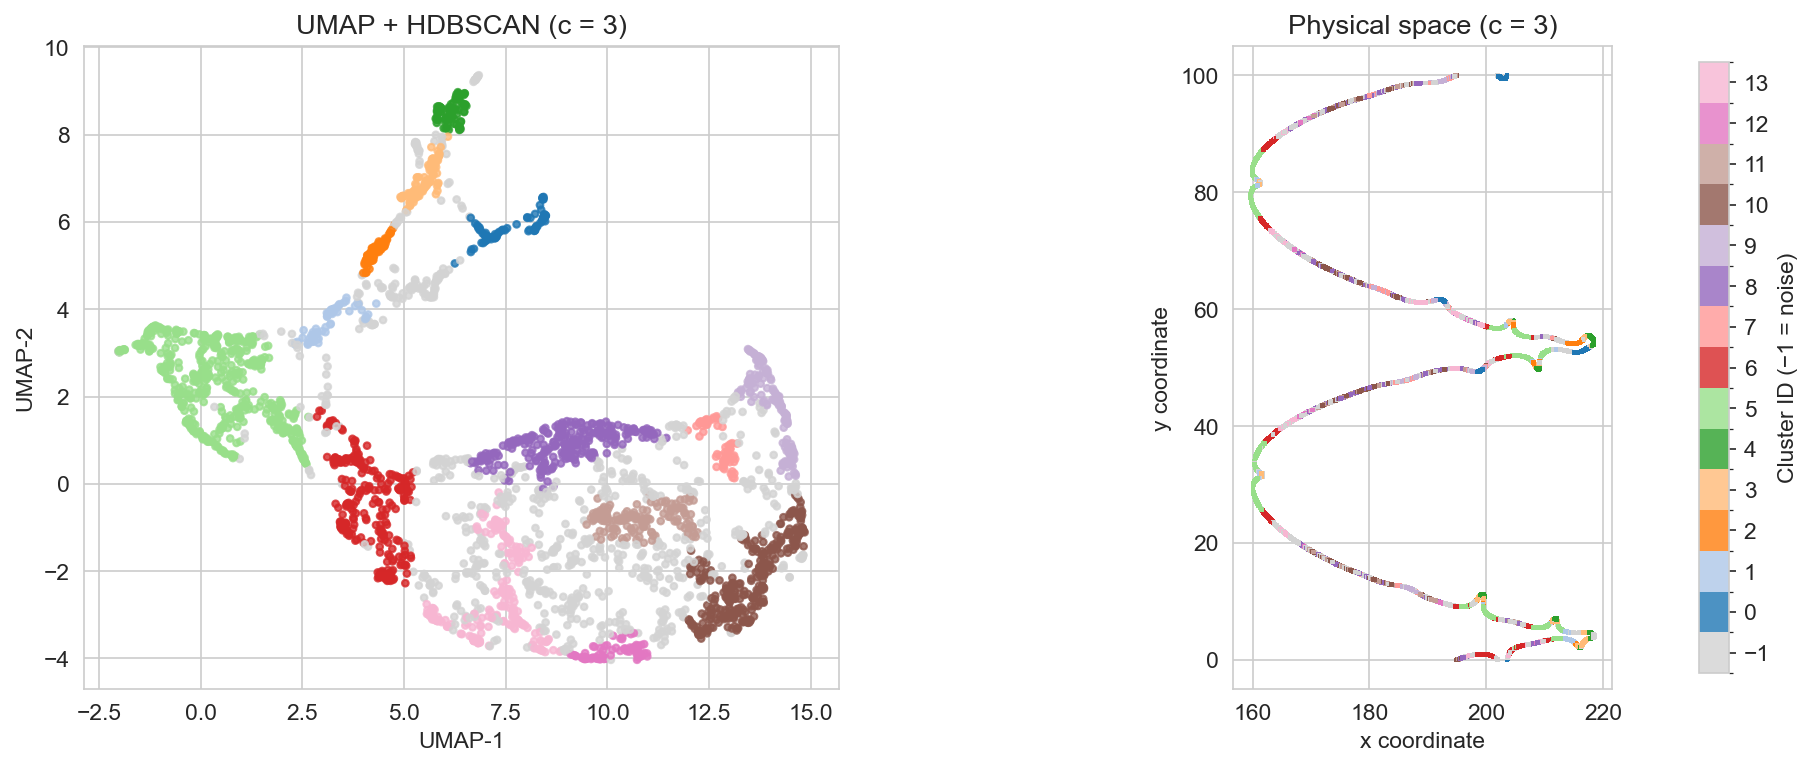

C:\Users\alexp\Documents\Bachelor Thesis\Code\.venv\Lib\site-packages\umap\umap_.py:1952: UserWarning: n_jobs value 1 overridden to 1 by setting random_state. Use no seed for parallelism.
  warn(


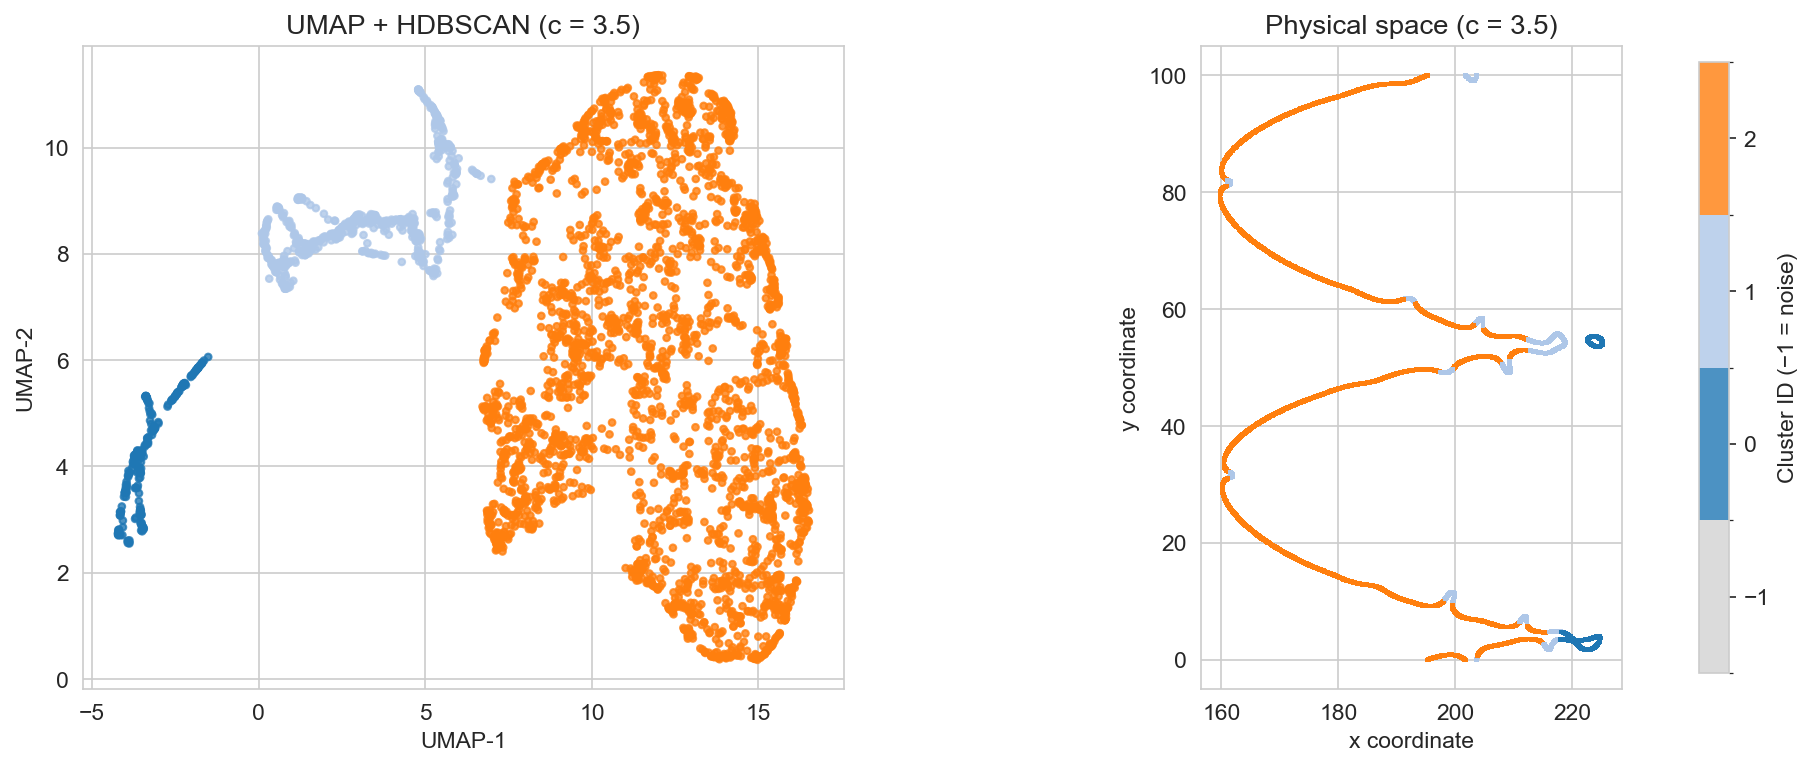

C:\Users\alexp\Documents\Bachelor Thesis\Code\.venv\Lib\site-packages\umap\umap_.py:1952: UserWarning: n_jobs value 1 overridden to 1 by setting random_state. Use no seed for parallelism.
  warn(


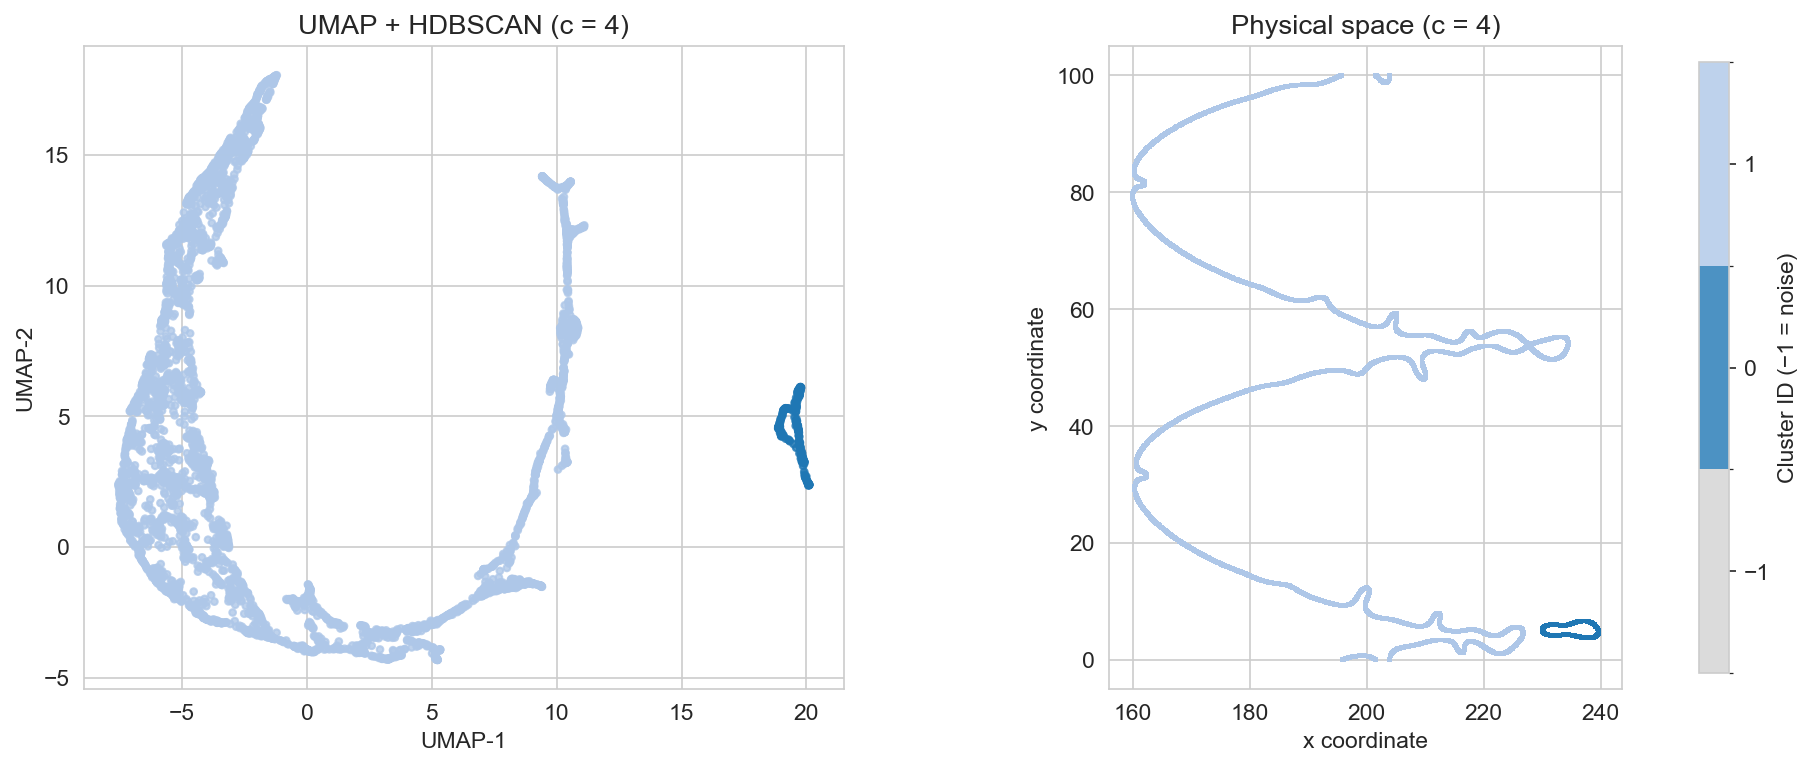

C:\Users\alexp\Documents\Bachelor Thesis\Code\.venv\Lib\site-packages\umap\umap_.py:1952: UserWarning: n_jobs value 1 overridden to 1 by setting random_state. Use no seed for parallelism.
  warn(


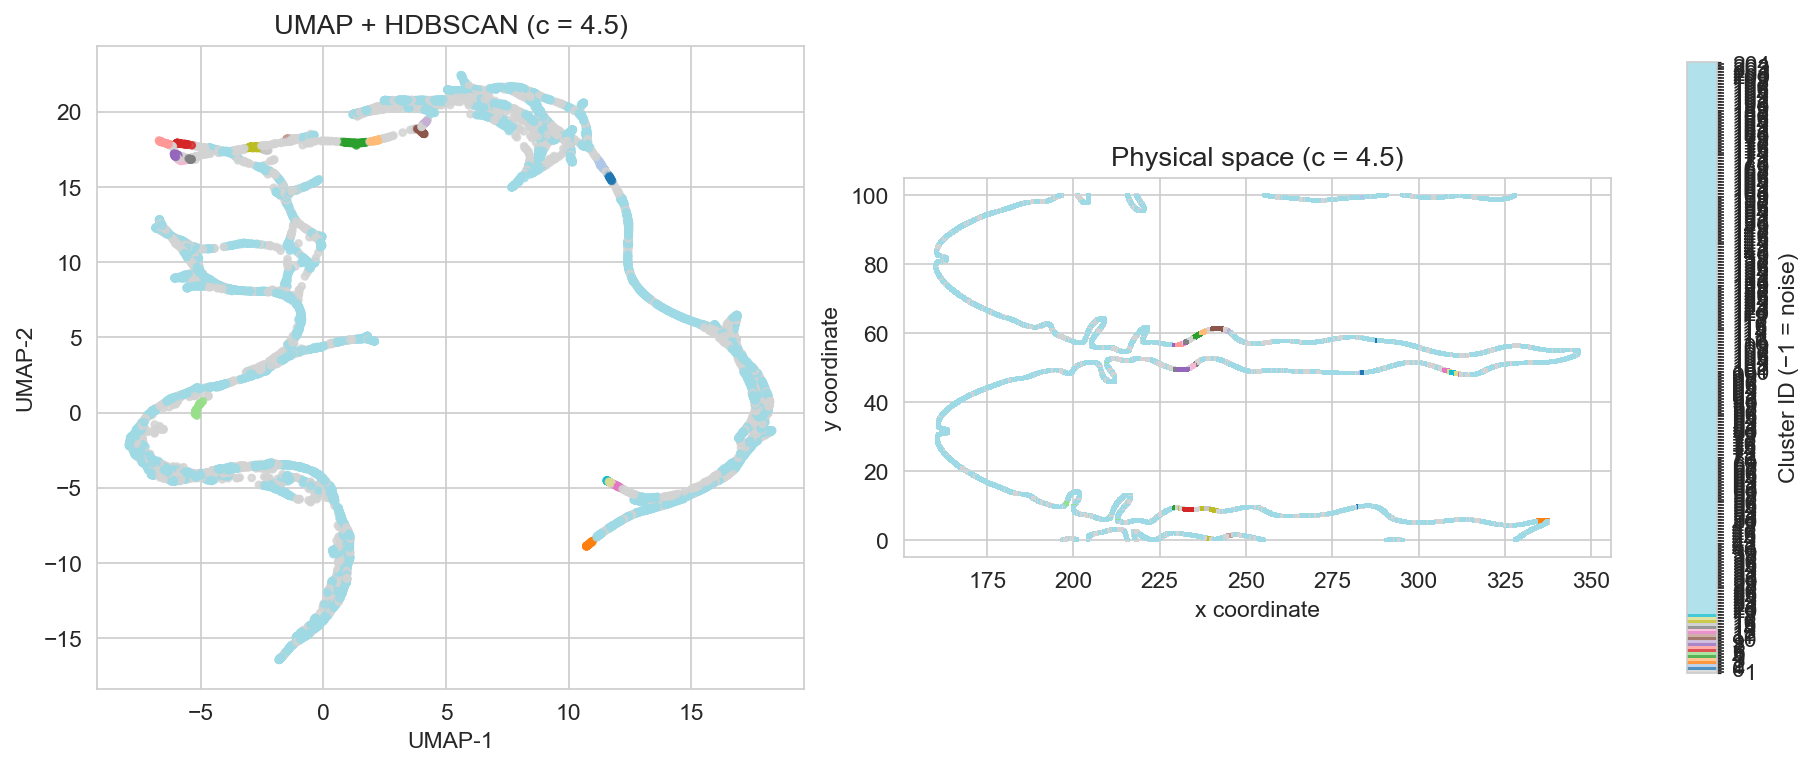

C:\Users\alexp\Documents\Bachelor Thesis\Code\.venv\Lib\site-packages\umap\umap_.py:1952: UserWarning: n_jobs value 1 overridden to 1 by setting random_state. Use no seed for parallelism.
  warn(


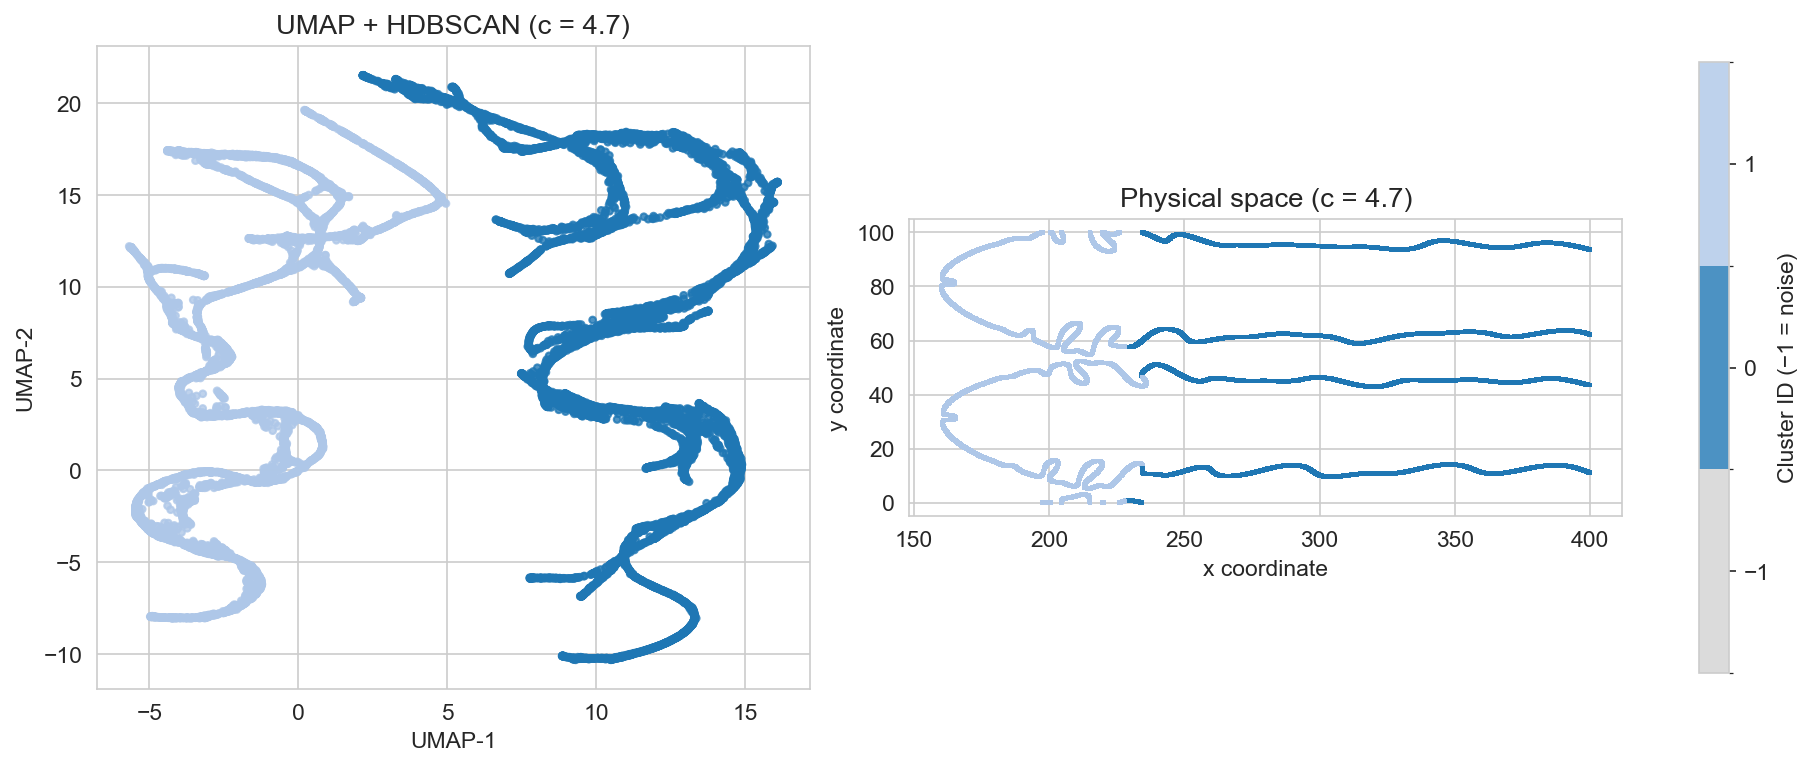

In [47]:
feature_setting = 0
n_neighbours = [50,50,50,50,50,50]
init = 'spectral'
min_cluster_size= [50,50,50,50,10,50]
min_samples= [20,20,20,20,10,20]


# ============================================================
# STORAGE DICTIONARY FOR LATER USE
# ============================================================
all_cluster_results = {}   # <-- NEW: store everything here
# Keys will be isolevels: c_val



if feature_setting:
    plot_title = "reaction"
else:
    plot_title = "state"

print(f"phi{phi:.2f}/h400x{lat_size}_ref")
print(f"Isolevels: {isolevels}")
print(f"Feature setting: {plot_title}")


# --------------------------------------------------------------
# Select features
# --------------------------------------------------------------
if feature_setting == 0:
    features = ['H2', 'O2', 'H2O', 'H', 'O', 'OH', 'HO2', 'H2O2']
else:
    features = [
        'omega_H2', 'omega_O2', 'omega_H2O', 'omega_H', 'omega_O', 'omega_OH',
        'omega_HO2', 'omega_H2O2', 'HRR'
    ]

# --------------------------------------------------------------
# Loop over isocontours
# --------------------------------------------------------------
for c_idx, c_val in enumerate(isolevels):

    front = pd.read_csv(
        f"../data/isocontours/phi{phi:.2f}/h400x{lat_size}_ref/"
        f"extracted_flame_front_{time_step}_iso_{c_val}.csv"
    )

    X_raw = front[features].to_numpy()
    X_scaled = StandardScaler().fit_transform(X_raw)

    # UMAP embedding
    reducer = umap.UMAP(
        n_neighbors=n_neighbours[c_idx],
        n_components=2,
        random_state=42,
        init=init
    )
    X_embedded = reducer.fit_transform(X_scaled)

    # HDBSCAN clustering
    clusterer = hdbscan.HDBSCAN(
        min_cluster_size=min_cluster_size[c_idx],
        min_samples=min_samples[c_idx],
        metric='euclidean',
        cluster_selection_method='eom',
        prediction_data=True,
    ).fit(X_embedded)

    labels = clusterer.labels_
    proba  = clusterer.probabilities_
    outlier_scores = clusterer.outlier_scores_

    # ============================================================
    # COMMON COLORMAP + NORM FOR ALL PLOTS
    # ============================================================
    labels_unique = np.unique(labels)

    # Number of real clusters (ignore noise = -1)
    n_clusters = np.sum(labels_unique >= 0)

    # Base colormap for clusters
    base_cmap = mpl.colormaps['tab20']  # or any other you like

    # Build a ListedColormap so we can control noise color
    colors = ['lightgrey']  # color for noise (-1)
    colors += [base_cmap(i) for i in range(n_clusters)]
    cmap = mpl.colors.ListedColormap(colors)

    # Bounds: -1.5, -0.5, 0.5, ..., (n_clusters - 0.5)
    bounds = np.arange(-1.5, n_clusters + 0.5, 1)
    norm = mpl.colors.BoundaryNorm(bounds, cmap.N)

    # ============================================================
    # COMBINED FIGURE: UMAP (LEFT) + PHYSICAL SPACE (RIGHT)
    # ============================================================
    fig, (ax_umap, ax_phys) = plt.subplots(
        1, 2, figsize=(12, 5), constrained_layout=True
    )

    # ---- 1) UMAP SPACE ----
    sc_umap = ax_umap.scatter(
        X_embedded[:, 0], X_embedded[:, 1],
        c=labels,
        cmap=cmap,
        norm=norm,
        s=10,
        alpha=0.8
    )
    ax_umap.set_title(f"UMAP + HDBSCAN (c = {c_val})")
    ax_umap.set_xlabel("UMAP-1")
    ax_umap.set_ylabel("UMAP-2")

    # ---- 2) PHYSICAL (x, y) SPACE ----
    sc_phys = ax_phys.scatter(
        front['x'],
        front['y'],
        c=labels,
        cmap=cmap,
        norm=norm,
        s=5,
        marker='s',
        linewidths=0
    )
    ax_phys.set_title(f"Physical space (c = {c_val})")
    ax_phys.set_xlabel("x coordinate")
    ax_phys.set_ylabel("y coordinate")
    ax_phys.set_aspect('equal', adjustable='box')

    # ---- SHARED COLORBAR FOR BOTH SUBPLOTS ----
    # use one of the scatter handles; cmap/norm are the same
    cb = fig.colorbar(
        sc_umap,
        ax=[ax_umap, ax_phys],
        ticks=np.arange(-1, n_clusters),
        shrink=0.95
    )
    cb.set_label("Cluster ID (−1 = noise)")

    plt.show()


## Each Iso seperately - Grid Search

In [34]:
from sklearn.metrics import silhouette_score


def run_hdbscan_and_score(
        X_embedded,
        min_cluster_size,
        min_samples,
        metric='euclidean',
        alpha_noise_penalty=0.5,
):
    """
    Run HDBSCAN and compute a robustness score based on:
      - silhouette score (only on non-noise points)
      - minus a penalty proportional to the noise fraction
    """
    clusterer = hdbscan.HDBSCAN(
        min_cluster_size=min_cluster_size,
        min_samples=min_samples,
        metric=metric,
        cluster_selection_method='eom',
        prediction_data=True,
    ).fit(X_embedded)

    labels = clusterer.labels_

    unique_labels = np.unique(labels)
    n_real_clusters = np.sum(unique_labels >= 0)

    # Reject degenerate cases: no clusters or only one cluster
    if n_real_clusters < 2:
        return -np.inf, labels, clusterer

    # Keep only non-noise points for silhouette calculation
    mask_core = labels >= 0
    X_core = X_embedded[mask_core]
    labels_core = labels[mask_core]

    # Extra safety: need at least 2 labels to compute silhouette
    if X_core.shape[0] < 2 or np.unique(labels_core).size < 2:
        return -np.inf, labels, clusterer

    try:
        base_score = silhouette_score(X_core, labels_core, metric=metric)
    except Exception:
        # Any numerical issue ⇒ reject this setting
        return -np.inf, labels, clusterer

    noise_fraction = np.mean(labels == -1)

    # Composite score: you can tune alpha_noise_penalty
    score = base_score - alpha_noise_penalty * noise_fraction

    return score, labels, clusterer


def search_best_umap_hdbscan_params(
        X_scaled,
        n_neighbors_grid,
        min_cluster_size_grid,
        min_samples_grid,
        init='spectral',
        metric='euclidean',
        alpha_noise_penalty=0.5,
        random_state=42,
):
    """
    Joint search over UMAP n_neighbors and HDBSCAN parameters.

    Parameters
    ----------
    X_scaled : ndarray
        Scaled feature matrix.
    n_neighbors_grid : list[int]
    min_cluster_size_grid : list[int]
    min_samples_grid : list[int]

    Returns
    -------
    best_result : dict
        Keys:
            'score', 'n_neighbors', 'min_cluster_size', 'min_samples',
            'labels', 'clusterer', 'X_embedded', 'reducer'
    """
    best_score = -np.inf
    best_result = None

    for nn in n_neighbors_grid:
        # --- UMAP embedding for this n_neighbors ---
        reducer = umap.UMAP(
            n_neighbors=nn,
            n_components=2,
            random_state=random_state,
            init=init
        )
        X_embedded = reducer.fit_transform(X_scaled)

        for mcs in min_cluster_size_grid:
            for ms in min_samples_grid:
                # often sensible to keep min_samples <= min_cluster_size
                if ms > mcs:
                    continue

                score, labels, clusterer = run_hdbscan_and_score(
                    X_embedded,
                    min_cluster_size=mcs,
                    min_samples=ms,
                    metric=metric,
                    alpha_noise_penalty=alpha_noise_penalty,
                )

                n_clusters = np.sum(np.unique(labels) >= 0)
                noise_frac = np.mean(labels == -1)

                print(
                    f"n_neighbors={nn:3d}, "
                    f"min_cluster_size={mcs:3d}, min_samples={ms:3d}, "
                    f"score={score: .4f}, n_clusters={n_clusters}, "
                    f"noise_frac={noise_frac:.2f}"
                )

                if score > best_score:
                    best_score = score
                    best_result = {
                        "score": best_score,
                        "n_neighbors": nn,
                        "min_cluster_size": mcs,
                        "min_samples": ms,
                        "labels": labels,
                        "clusterer": clusterer,
                        "X_embedded": X_embedded,
                        "reducer": reducer,
                    }

    if best_result is None:
        raise RuntimeError(
            "All UMAP+HDBSCAN parameter combinations were rejected "
            "(score = -inf). Try relaxing the grids or the scoring rules."
        )

    return best_result


In [42]:

feature_setting = 0

if feature_setting:
    plot_title = "reaction"
else:
    plot_title = "state"

if feature_setting == 0:
    features = ['H2', 'O2', 'H2O', 'H', 'O', 'OH', 'HO2', 'H2O2']
else:
    features = [
        'omega_H2', 'omega_O2', 'omega_H2O', 'omega_H', 'omega_O', 'omega_OH',
        'omega_HO2', 'omega_H2O2', 'HRR'
    ]

c_val = isolevels[-2]

front = pd.read_csv(
    f"../data/isocontours/phi{phi:.2f}/h400x{lat_size}_ref/"
    f"extracted_flame_front_{time_step}_iso_{c_val}.csv"
)

X_raw = front[features].to_numpy()
X_scaled = StandardScaler().fit_transform(X_raw)

# grids
n_neighbors_grid = [10,20,30,40,50]
min_cluster_size_grid = [10, 20, 30, 50, 80, 120, 160, 200]
min_samples_grid = [5, 10, 20, 30, 40, 50]

best = search_best_umap_hdbscan_params(
    X_scaled,
    n_neighbors_grid=n_neighbors_grid,
    min_cluster_size_grid=min_cluster_size_grid,
    min_samples_grid=min_samples_grid,
    init=init,  # your existing init (e.g. 'spectral')
    metric='euclidean',
    alpha_noise_penalty=0.5,  # tweak if you want less/more noise penalty
    random_state=42,
)

print("\nBest parameters:")
print(f"  n_neighbors      = {best['n_neighbors']}")
print(f"  min_cluster_size = {best['min_cluster_size']}")
print(f"  min_samples      = {best['min_samples']}")
print(f"  best score       = {best['score']:.4f}")

# If you want to reuse them:
X_embedded_best = best["X_embedded"]
labels = best["labels"]
clusterer = best["clusterer"]
reducer = best["reducer"]


C:\Users\alexp\Documents\Bachelor Thesis\Code\.venv\Lib\site-packages\umap\umap_.py:1952: UserWarning: n_jobs value 1 overridden to 1 by setting random_state. Use no seed for parallelism.
  warn(


n_neighbors= 10, min_cluster_size= 10, min_samples=  5, score= 0.5159, n_clusters=348, noise_frac=0.14
n_neighbors= 10, min_cluster_size= 10, min_samples= 10, score= 0.4825, n_clusters=267, noise_frac=0.22
n_neighbors= 10, min_cluster_size= 20, min_samples=  5, score= 0.4377, n_clusters=169, noise_frac=0.10
n_neighbors= 10, min_cluster_size= 20, min_samples= 10, score= 0.4404, n_clusters=142, noise_frac=0.15
n_neighbors= 10, min_cluster_size= 20, min_samples= 20, score= 0.4005, n_clusters=93, noise_frac=0.24
n_neighbors= 10, min_cluster_size= 30, min_samples=  5, score= 0.4047, n_clusters=117, noise_frac=0.11
n_neighbors= 10, min_cluster_size= 30, min_samples= 10, score= 0.4156, n_clusters=104, noise_frac=0.14
n_neighbors= 10, min_cluster_size= 30, min_samples= 20, score= 0.3845, n_clusters=69, noise_frac=0.21
n_neighbors= 10, min_cluster_size= 30, min_samples= 30, score= 0.1930, n_clusters=3, noise_frac=0.00
n_neighbors= 10, min_cluster_size= 50, min_samples=  5, score= 0.2419, n_clus

C:\Users\alexp\Documents\Bachelor Thesis\Code\.venv\Lib\site-packages\umap\umap_.py:1952: UserWarning: n_jobs value 1 overridden to 1 by setting random_state. Use no seed for parallelism.
  warn(


n_neighbors= 20, min_cluster_size= 10, min_samples=  5, score= 0.5109, n_clusters=328, noise_frac=0.15
n_neighbors= 20, min_cluster_size= 10, min_samples= 10, score= 0.5142, n_clusters=267, noise_frac=0.23
n_neighbors= 20, min_cluster_size= 20, min_samples=  5, score= 0.4584, n_clusters=181, noise_frac=0.14
n_neighbors= 20, min_cluster_size= 20, min_samples= 10, score= 0.4588, n_clusters=160, noise_frac=0.19
n_neighbors= 20, min_cluster_size= 20, min_samples= 20, score=-0.1491, n_clusters=40, noise_frac=0.06
n_neighbors= 20, min_cluster_size= 30, min_samples=  5, score= 0.4166, n_clusters=127, noise_frac=0.13
n_neighbors= 20, min_cluster_size= 30, min_samples= 10, score= 0.0234, n_clusters=73, noise_frac=0.10
n_neighbors= 20, min_cluster_size= 30, min_samples= 20, score=-0.1502, n_clusters=30, noise_frac=0.07
n_neighbors= 20, min_cluster_size= 30, min_samples= 30, score= 0.0852, n_clusters=3, noise_frac=0.00
n_neighbors= 20, min_cluster_size= 50, min_samples=  5, score=-0.0826, n_clust

C:\Users\alexp\Documents\Bachelor Thesis\Code\.venv\Lib\site-packages\umap\umap_.py:1952: UserWarning: n_jobs value 1 overridden to 1 by setting random_state. Use no seed for parallelism.
  warn(


n_neighbors= 30, min_cluster_size= 10, min_samples=  5, score= 0.4954, n_clusters=298, noise_frac=0.17
n_neighbors= 30, min_cluster_size= 10, min_samples= 10, score= 0.4872, n_clusters=225, noise_frac=0.23
n_neighbors= 30, min_cluster_size= 20, min_samples=  5, score= 0.4570, n_clusters=169, noise_frac=0.16
n_neighbors= 30, min_cluster_size= 20, min_samples= 10, score= 0.4480, n_clusters=145, noise_frac=0.19
n_neighbors= 30, min_cluster_size= 20, min_samples= 20, score= 0.4461, n_clusters=122, noise_frac=0.27
n_neighbors= 30, min_cluster_size= 30, min_samples=  5, score= 0.3804, n_clusters=119, noise_frac=0.12
n_neighbors= 30, min_cluster_size= 30, min_samples= 10, score= 0.4064, n_clusters=102, noise_frac=0.16
n_neighbors= 30, min_cluster_size= 30, min_samples= 20, score= 0.2130, n_clusters=67, noise_frac=0.17
n_neighbors= 30, min_cluster_size= 30, min_samples= 30, score= 0.3542, n_clusters=55, noise_frac=0.22
n_neighbors= 30, min_cluster_size= 50, min_samples=  5, score= 0.2657, n_cl

C:\Users\alexp\Documents\Bachelor Thesis\Code\.venv\Lib\site-packages\umap\umap_.py:1952: UserWarning: n_jobs value 1 overridden to 1 by setting random_state. Use no seed for parallelism.
  warn(


n_neighbors= 40, min_cluster_size= 10, min_samples=  5, score= 0.4805, n_clusters=290, noise_frac=0.19
n_neighbors= 40, min_cluster_size= 10, min_samples= 10, score= 0.4921, n_clusters=223, noise_frac=0.26
n_neighbors= 40, min_cluster_size= 20, min_samples=  5, score= 0.4584, n_clusters=167, noise_frac=0.16
n_neighbors= 40, min_cluster_size= 20, min_samples= 10, score= 0.4610, n_clusters=147, noise_frac=0.20
n_neighbors= 40, min_cluster_size= 20, min_samples= 20, score= 0.4029, n_clusters=110, noise_frac=0.24
n_neighbors= 40, min_cluster_size= 30, min_samples=  5, score= 0.2556, n_clusters=80, noise_frac=0.11
n_neighbors= 40, min_cluster_size= 30, min_samples= 10, score= 0.4041, n_clusters=105, noise_frac=0.18
n_neighbors= 40, min_cluster_size= 30, min_samples= 20, score= 0.3020, n_clusters=75, noise_frac=0.19
n_neighbors= 40, min_cluster_size= 30, min_samples= 30, score= 0.3819, n_clusters=2, noise_frac=0.00
n_neighbors= 40, min_cluster_size= 50, min_samples=  5, score= 0.1256, n_clus

C:\Users\alexp\Documents\Bachelor Thesis\Code\.venv\Lib\site-packages\umap\umap_.py:1952: UserWarning: n_jobs value 1 overridden to 1 by setting random_state. Use no seed for parallelism.
  warn(


n_neighbors= 50, min_cluster_size= 10, min_samples=  5, score= 0.4660, n_clusters=270, noise_frac=0.19
n_neighbors= 50, min_cluster_size= 10, min_samples= 10, score= 0.4565, n_clusters=205, noise_frac=0.24
n_neighbors= 50, min_cluster_size= 20, min_samples=  5, score= 0.4473, n_clusters=165, noise_frac=0.16
n_neighbors= 50, min_cluster_size= 20, min_samples= 10, score= 0.4282, n_clusters=141, noise_frac=0.19
n_neighbors= 50, min_cluster_size= 20, min_samples= 20, score= 0.4079, n_clusters=105, noise_frac=0.23
n_neighbors= 50, min_cluster_size= 30, min_samples=  5, score= 0.4139, n_clusters=121, noise_frac=0.15
n_neighbors= 50, min_cluster_size= 30, min_samples= 10, score= 0.4232, n_clusters=100, noise_frac=0.19
n_neighbors= 50, min_cluster_size= 30, min_samples= 20, score= 0.3884, n_clusters=65, noise_frac=0.18
n_neighbors= 50, min_cluster_size= 30, min_samples= 30, score= 0.4181, n_clusters=56, noise_frac=0.24
n_neighbors= 50, min_cluster_size= 50, min_samples=  5, score= 0.3396, n_cl

C:\Users\alexp\Documents\Bachelor Thesis\Code\.venv\Lib\site-packages\umap\umap_.py:1952: UserWarning: n_jobs value 1 overridden to 1 by setting random_state. Use no seed for parallelism.
  warn(


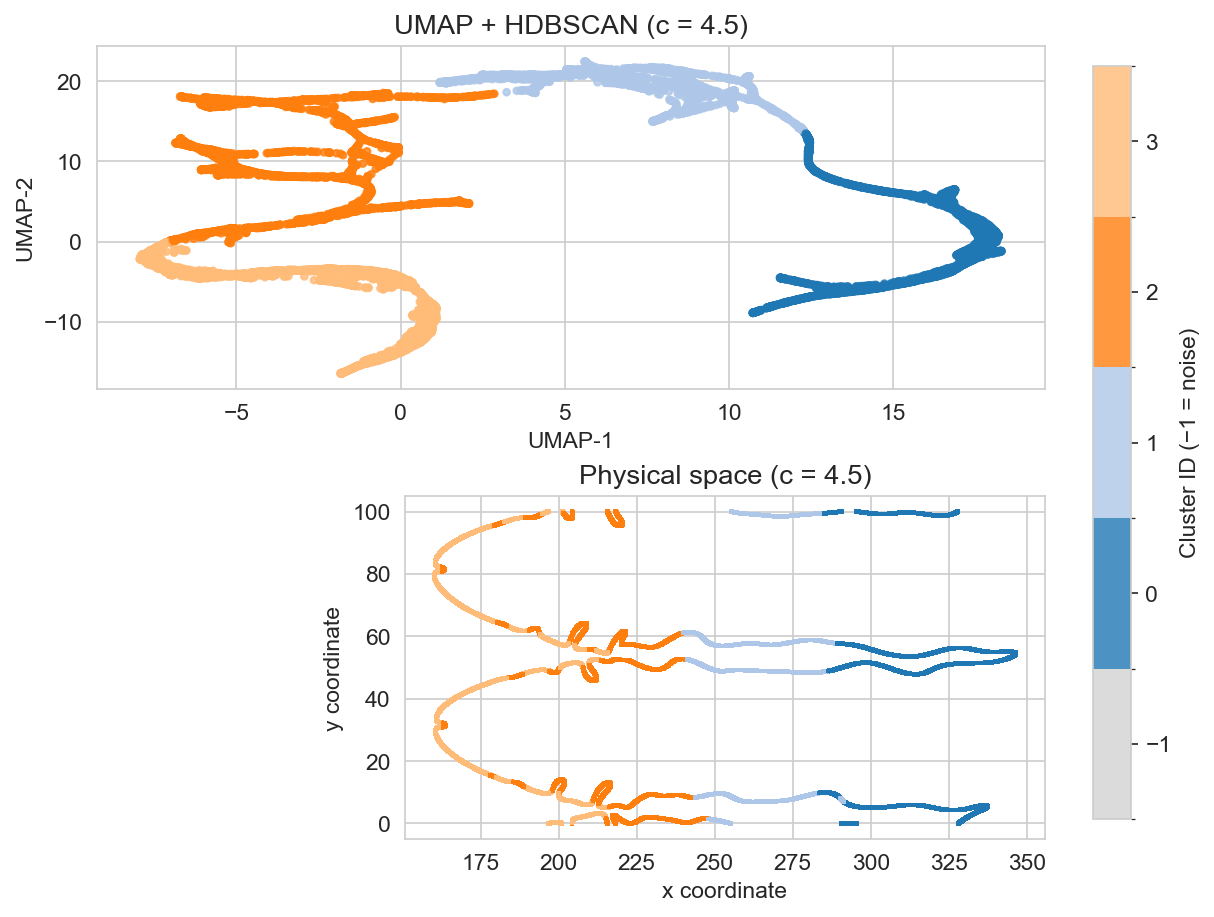

In [43]:
reducer = umap.UMAP(
    n_neighbors=best['n_neighbors'],
    n_components=2,
    random_state=42,
    init=init
)
X_embedded = reducer.fit_transform(X_scaled)
# HDBSCAN clustering
clusterer = hdbscan.HDBSCAN(
    min_cluster_size=best['min_cluster_size'],
    min_samples=best['min_samples'],
    metric='euclidean',
    cluster_selection_method='eom',
    prediction_data=True,
).fit(X_embedded)

labels = clusterer.labels_
proba  = clusterer.probabilities_
outlier_scores = clusterer.outlier_scores_

# ============================================================
# COMMON COLORMAP + NORM FOR ALL PLOTS
# ============================================================
labels_unique = np.unique(labels)

# Number of real clusters (ignore noise = -1)
n_clusters = np.sum(labels_unique >= 0)

# Base colormap for clusters
base_cmap = mpl.colormaps['tab20']  # or any other you like

# Build a ListedColormap so we can control noise color
colors = ['lightgrey']  # color for noise (-1)
colors += [base_cmap(i) for i in range(n_clusters)]
cmap = mpl.colors.ListedColormap(colors)

# Bounds: -1.5, -0.5, 0.5, ..., (n_clusters - 0.5)
bounds = np.arange(-1.5, n_clusters + 0.5, 1)
norm = mpl.colors.BoundaryNorm(bounds, cmap.N)

# ============================================================
# COMBINED FIGURE: UMAP (LEFT) + PHYSICAL SPACE (RIGHT)
# ============================================================
fig, (ax_umap, ax_phys) = plt.subplots(
    2, 1, figsize=(8, 6), constrained_layout=True
)

# ---- 1) UMAP SPACE ----
sc_umap = ax_umap.scatter(
    X_embedded[:, 0], X_embedded[:, 1],
    c=labels,
    cmap=cmap,
    norm=norm,
    s=10,
    alpha=0.8
)
ax_umap.set_title(f"UMAP + HDBSCAN (c = {c_val})")
ax_umap.set_xlabel("UMAP-1")
ax_umap.set_ylabel("UMAP-2")

# ---- 2) PHYSICAL (x, y) SPACE ----
sc_phys = ax_phys.scatter(
    front['x'],
    front['y'],
    c=labels,
    cmap=cmap,
    norm=norm,
    s=5,
    marker='s',
    linewidths=0
)
ax_phys.set_title(f"Physical space (c = {c_val})")
ax_phys.set_xlabel("x coordinate")
ax_phys.set_ylabel("y coordinate")
ax_phys.set_aspect('equal', adjustable='box')

# ---- SHARED COLORBAR FOR BOTH SUBPLOTS ----
# use one of the scatter handles; cmap/norm are the same
cb = fig.colorbar(
    sc_umap,
    ax=[ax_umap, ax_phys],
    ticks=np.arange(-1, n_clusters),
    shrink=0.95
)
cb.set_label("Cluster ID (−1 = noise)")

plt.show()